# XGBoost Hyperparameter Tuning

**Ziel:** Optimierung des besten ML-Modells aus Phase 1

**Strategie:**
1. Random Search für schnelle Exploration
2. Grid Search für feine Abstimmung
3. Time-Series Cross-Validation

**Parameter zu optimieren:**
- `n_estimators`: Anzahl der Bäume (100-1000)
- `max_depth`: Baumtiefe (3-10)
- `learning_rate`: Lernrate (0.01-0.3)
- `subsample`: Datenstichprobe pro Baum (0.7-1.0)
- `colsample_bytree`: Feature-Stichprobe pro Baum (0.7-1.0)
- `min_child_weight`: Minimum samples in leaf (1-10)

**Baseline:** MAE ~246 MW, R² ~0.983

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Custom modules
from evaluation.metrics import calculate_metrics, print_metrics
from visualization.plots import plot_forecast

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ Libraries loaded")

✅ Libraries loaded


## 1. Daten laden

In [2]:
DATA_TYPE = 'solar'
data_dir = Path('../data/processed')

# Load non-scaled data (XGBoost works better with original scale)
train_df = pd.read_csv(data_dir / f'{DATA_TYPE}_train.csv', parse_dates=['timestamp'])
val_df = pd.read_csv(data_dir / f'{DATA_TYPE}_val.csv', parse_dates=['timestamp'])
test_df = pd.read_csv(data_dir / f'{DATA_TYPE}_test.csv', parse_dates=['timestamp'])

print(f"Train: {len(train_df)} samples")
print(f"Val:   {len(val_df)} samples")
print(f"Test:  {len(test_df)} samples")
print(f"\nValue range: [{train_df['value'].min():.0f}, {train_df['value'].max():.0f}] MW")

Train: 18262 samples
Val:   3913 samples
Test:  3914 samples

Value range: [1, 41246] MW


## 2. Feature Engineering

Erstelle die gleichen Features wie in `05_ml_tree_models.ipynb`

In [3]:
def create_features(df):
    """Create time-based features for tree models"""
    df = df.copy()
    
    # Time features
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['week'] = df['timestamp'].dt.isocalendar().week
    df['quarter'] = df['timestamp'].dt.quarter
    
    # Cyclical encoding for hour and month
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Lag features (previous hours)
    for lag in [1, 2, 3, 24, 168]:  # 1h, 2h, 3h, 1day, 1week
        df[f'lag_{lag}'] = df['value'].shift(lag)
    
    # Rolling statistics
    for window in [24, 168]:  # 1 day, 1 week
        df[f'rolling_mean_{window}'] = df['value'].shift(1).rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['value'].shift(1).rolling(window=window).std()
    
    return df

# Apply feature engineering
train_df = create_features(train_df)
val_df = create_features(val_df)
test_df = create_features(test_df)

# Drop NaN from lag/rolling features
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

print(f"✅ Features created: {train_df.shape[1] - 2} features")  # -2 for timestamp and value
print(f"\nAfter dropna:")
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

✅ Features created: 36 features

After dropna:
Train: 18094 | Val: 3745 | Test: 3746


## 3. Prepare Data

In [4]:
# Define features
feature_cols = [col for col in train_df.columns if col not in ['timestamp', 'value']]

X_train = train_df[feature_cols]
y_train = train_df['value']

X_val = val_df[feature_cols]
y_val = val_df['value']

X_test = test_df[feature_cols]
y_test = test_df['value']

print(f"Feature matrix shape: {X_train.shape}")
print(f"\nFeatures: {', '.join(feature_cols[:5])}...")

Feature matrix shape: (18094, 36)

Features: year, month, day, dayofweek, dayofyear...


## 4. Baseline Model

Reproduziere die Baseline aus `05_ml_tree_models.ipynb`

In [5]:
print("Training Baseline XGBoost...\n")

baseline_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Predict
y_pred_baseline = baseline_model.predict(X_test)

# Metrics
baseline_metrics = calculate_metrics(y_test, y_pred_baseline, prefix='test_')
print_metrics(baseline_metrics, "Baseline XGBoost")

print(f"\n📊 Baseline Performance:")
print(f"   MAE:  {baseline_metrics['test_mae']:.2f} MW")
print(f"   RMSE: {baseline_metrics['test_rmse']:.2f} MW")
print(f"   R²:   {baseline_metrics['test_r2']:.4f}")

Training Baseline XGBoost...

                      Baseline XGBoost                      
  test_mae       :     345.51
  test_rmse      :     763.71
  test_mape      :      73.64%
  test_smape     :      51.65%
  test_r2        :     0.9944
  test_mase      :       0.20

📊 Baseline Performance:
   MAE:  345.51 MW
   RMSE: 763.71 MW
   R²:   0.9944


## 5. Random Search

**Strategie:** Breite Exploration des Hyperparameter-Raums

In [6]:
from scipy.stats import randint, uniform

# Parameter distributions for random search
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.29),  # 0.01 to 0.3
    'subsample': uniform(0.7, 0.3),        # 0.7 to 1.0
    'colsample_bytree': uniform(0.7, 0.3), # 0.7 to 1.0
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5)
}

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

# Base model
base_model = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    tree_method='hist'  # Faster training
)

print("Starting Random Search...")
print(f"Parameter space: {len(param_distributions)} parameters")
print(f"Iterations: 50")
print(f"CV Folds: 3\n")

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit on train + val
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

random_search.fit(X_train_val, y_train_val)

print("\n✅ Random Search completed")
print(f"\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV MAE: {-random_search.best_score_:.2f} MW")

Starting Random Search...
Parameter space: 7 parameters
Iterations: 50
CV Folds: 3

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.22227824312530747, max_depth=7, min_child_weight=5, n_estimators=714, subsample=0.8337498258560773; total time=   3.6s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.22227824312530747, max_depth=7, min_child_weight=5, n_estimators=714, subsample=0.8337498258560773; total time=   4.3s
[CV] END colsample_bytree=0.7299924747454009, gamma=0.22962444598293358, learning_rate=0.10677549723031632, max_depth=5, min_child_weight=6, n_estimators=408, subsample=0.9909729556485982; total time=   1.2s
[CV] END colsample_bytree=0.7299924747454009, gamma=0.22962444598293358, learning_rate=0.10677549723031632, max_depth=5, min_child_weight=6, n_estimators=408, subsample=0.9909729556485982; total time=   1.8s
[CV] END colsample_bytre

## 6. Evaluate Best Model

In [7]:
# Get best model from random search
best_model = random_search.best_estimator_

# Predict on test set
y_pred_tuned = best_model.predict(X_test)

# Calculate metrics
tuned_metrics = calculate_metrics(y_test, y_pred_tuned, prefix='test_')
print_metrics(tuned_metrics, "Tuned XGBoost")

# Compare with baseline
print("\n" + "=" * 80)
print("BASELINE vs TUNED COMPARISON")
print("=" * 80)

comparison = pd.DataFrame({
    'Baseline': baseline_metrics,
    'Tuned': tuned_metrics
}).T

display(comparison[['test_mae', 'test_rmse', 'test_mape', 'test_r2']].round(4))

# Calculate improvement
mae_improvement = (baseline_metrics['test_mae'] - tuned_metrics['test_mae']) / baseline_metrics['test_mae'] * 100
rmse_improvement = (baseline_metrics['test_rmse'] - tuned_metrics['test_rmse']) / baseline_metrics['test_rmse'] * 100

print(f"\n📈 Improvement:")
print(f"   MAE:  {mae_improvement:+.2f}%")
print(f"   RMSE: {rmse_improvement:+.2f}%")

                       Tuned XGBoost                        
  test_mae       :     271.89
  test_rmse      :     540.54
  test_mape      :      57.95%
  test_smape     :      43.59%
  test_r2        :     0.9972
  test_mase      :       0.16

BASELINE vs TUNED COMPARISON


,test_mae,test_rmse,test_mape,test_r2
Baseline,345.5138,763.7128,73.6368,0.9944
Tuned,271.8885,540.5397,57.9520,0.9972



📈 Improvement:
   MAE:  +21.31%
   RMSE: +29.22%


## 7. Feature Importance Analysis

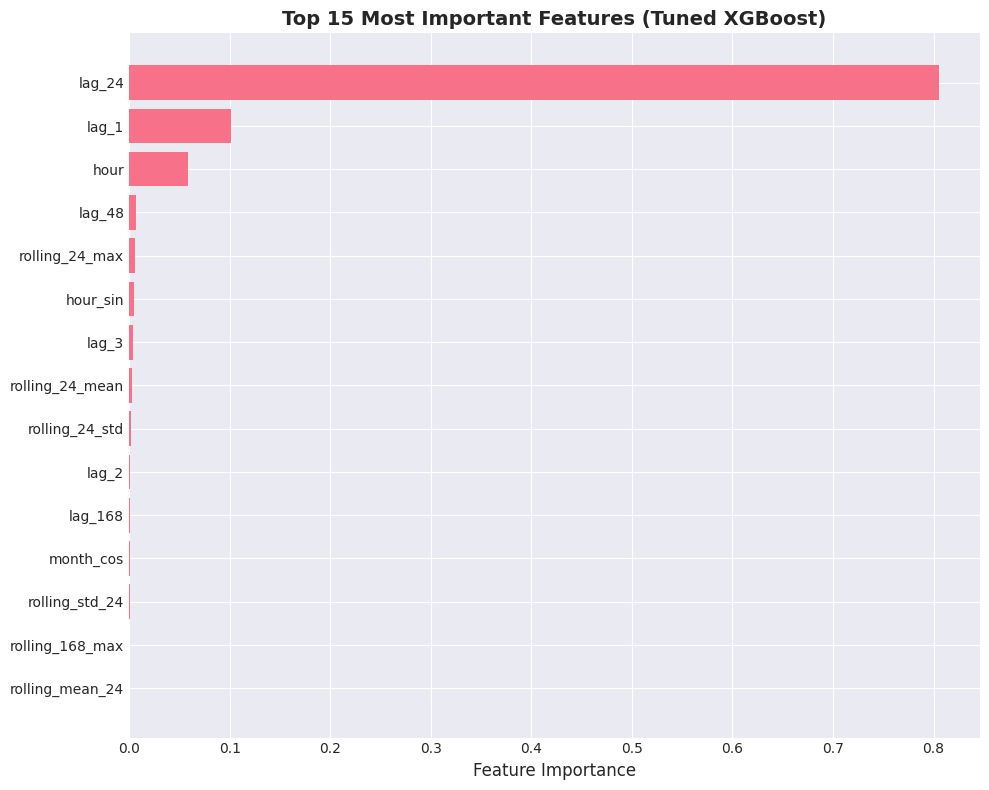


Top 10 Features:
  lag_24              : 0.8059
  lag_1               : 0.1009
  hour                : 0.0589
  lag_48              : 0.0069
  rolling_24_max      : 0.0055
  hour_sin            : 0.0050
  lag_3               : 0.0035
  rolling_24_mean     : 0.0030
  rolling_24_std      : 0.0022
  lag_2               : 0.0012


In [8]:
# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'].head(15)[::-1], 
         importance_df['importance'].head(15)[::-1])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 15 Most Important Features (Tuned XGBoost)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
for i, row in importance_df.head(10).iterrows():
    print(f"  {row['feature']:20s}: {row['importance']:.4f}")

## 8. Prediction Visualization

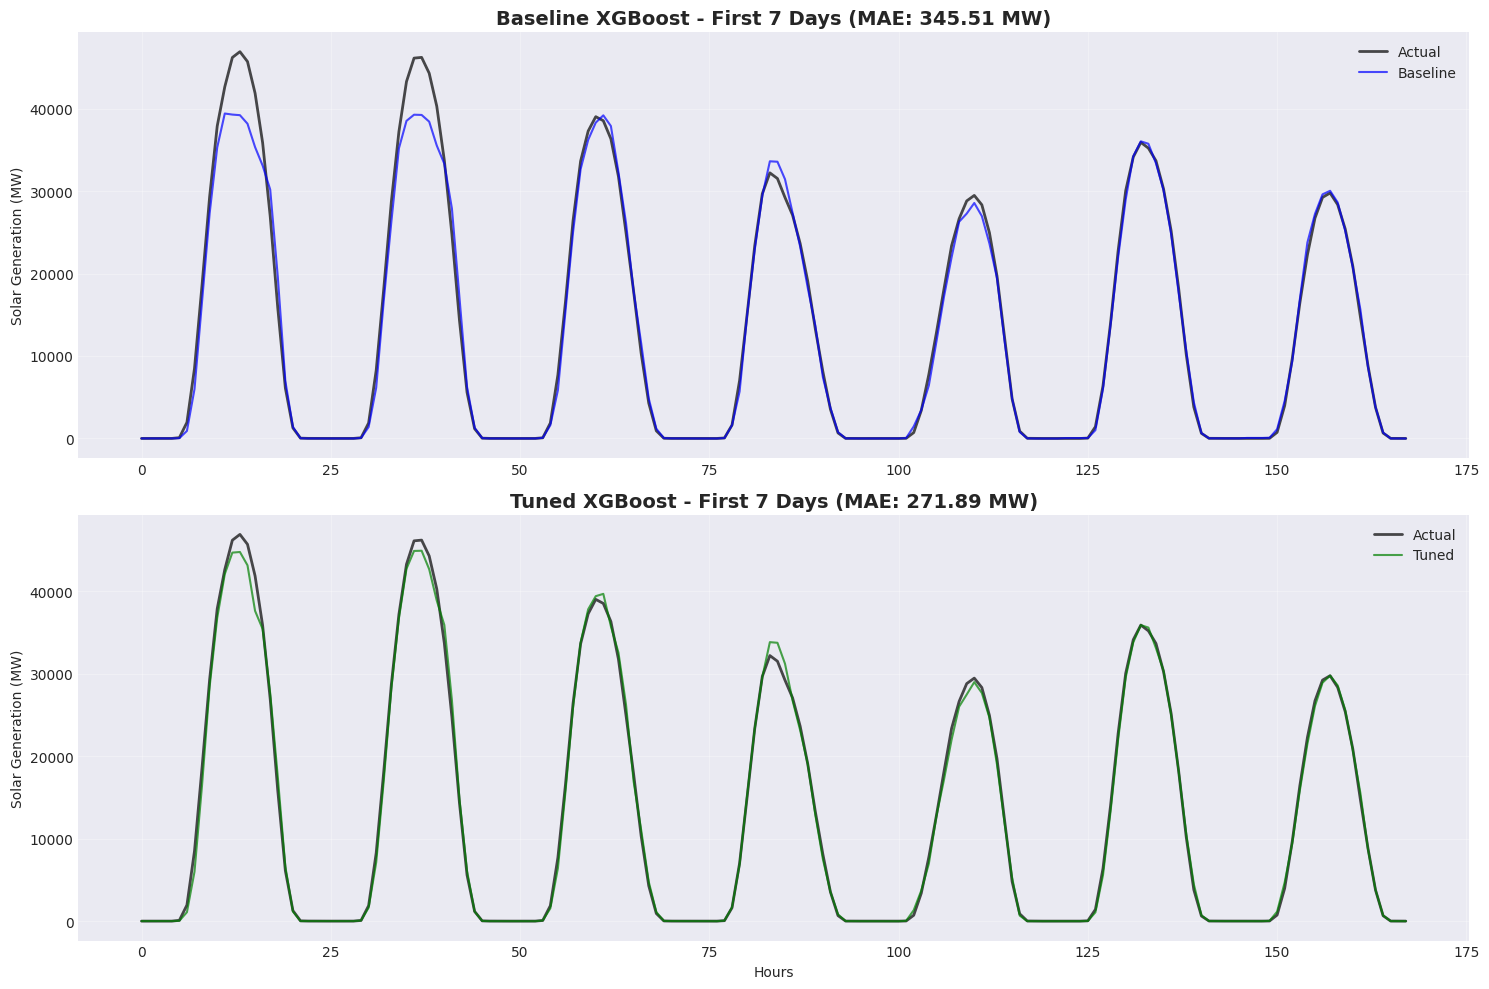

In [9]:
# Plot first 7 days (168 hours)
plot_len = 168

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Baseline
axes[0].plot(y_test.values[:plot_len], label='Actual', color='black', alpha=0.7, linewidth=2)
axes[0].plot(y_pred_baseline[:plot_len], label='Baseline', color='blue', alpha=0.7)
axes[0].set_title(f'Baseline XGBoost - First 7 Days (MAE: {baseline_metrics["test_mae"]:.2f} MW)', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Solar Generation (MW)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Tuned
axes[1].plot(y_test.values[:plot_len], label='Actual', color='black', alpha=0.7, linewidth=2)
axes[1].plot(y_pred_tuned[:plot_len], label='Tuned', color='green', alpha=0.7)
axes[1].set_title(f'Tuned XGBoost - First 7 Days (MAE: {tuned_metrics["test_mae"]:.2f} MW)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hours')
axes[1].set_ylabel('Solar Generation (MW)')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Error Analysis

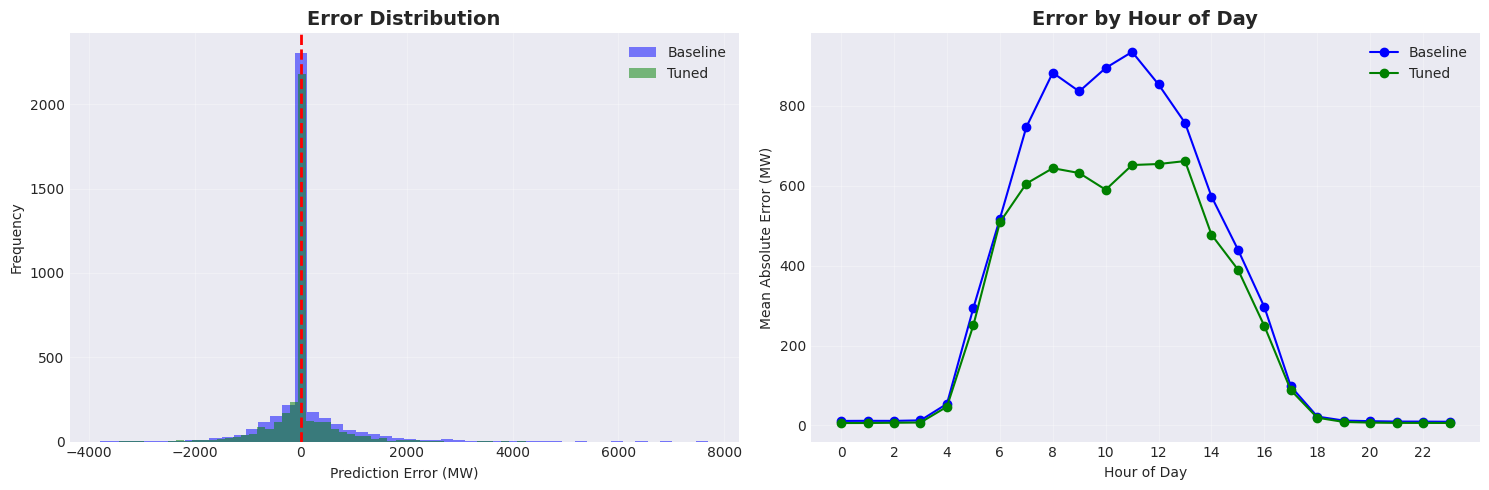


📊 Error Statistics:

Baseline:
  Mean Error:   71.98 MW
  Std Error:    760.31 MW

Tuned:
  Mean Error:   2.17 MW
  Std Error:    540.54 MW


In [10]:
# Calculate residuals
baseline_errors = y_test.values - y_pred_baseline
tuned_errors = y_test.values - y_pred_tuned

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residuals distribution
axes[0].hist(baseline_errors, bins=50, alpha=0.5, label='Baseline', color='blue')
axes[0].hist(tuned_errors, bins=50, alpha=0.5, label='Tuned', color='green')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Prediction Error (MW)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Error Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error by hour of day
test_df_with_pred = test_df.copy()
test_df_with_pred['baseline_error'] = np.abs(baseline_errors)
test_df_with_pred['tuned_error'] = np.abs(tuned_errors)

hourly_errors_baseline = test_df_with_pred.groupby('hour')['baseline_error'].mean()
hourly_errors_tuned = test_df_with_pred.groupby('hour')['tuned_error'].mean()

axes[1].plot(hourly_errors_baseline.index, hourly_errors_baseline.values, 
             marker='o', label='Baseline', color='blue')
axes[1].plot(hourly_errors_tuned.index, hourly_errors_tuned.values, 
             marker='o', label='Tuned', color='green')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Mean Absolute Error (MW)')
axes[1].set_title('Error by Hour of Day', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

print(f"\n📊 Error Statistics:")
print(f"\nBaseline:")
print(f"  Mean Error:   {baseline_errors.mean():.2f} MW")
print(f"  Std Error:    {baseline_errors.std():.2f} MW")
print(f"\nTuned:")
print(f"  Mean Error:   {tuned_errors.mean():.2f} MW")
print(f"  Std Error:    {tuned_errors.std():.2f} MW")

## 10. Save Results

In [11]:
# Save tuned model results
results_df = pd.DataFrame({
    'model': ['XGBoost_baseline', 'XGBoost_tuned'],
    **{k: [baseline_metrics[k], tuned_metrics[k]] for k in baseline_metrics.keys()}
})

results_df.to_csv('../results/metrics/solar_xgboost_tuning_results.csv', index=False)
print("✅ Results saved to: results/metrics/solar_xgboost_tuning_results.csv")

# Save best parameters
best_params_df = pd.DataFrame([random_search.best_params_])
best_params_df.to_csv('../results/metrics/xgboost_best_params.csv', index=False)
print("✅ Best parameters saved to: results/metrics/xgboost_best_params.csv")

# Save feature importance
importance_df.to_csv('../results/metrics/xgboost_feature_importance_tuned.csv', index=False)
print("✅ Feature importance saved to: results/metrics/xgboost_feature_importance_tuned.csv")

✅ Results saved to: results/metrics/solar_xgboost_tuning_results.csv
✅ Best parameters saved to: results/metrics/xgboost_best_params.csv
✅ Feature importance saved to: results/metrics/xgboost_feature_importance_tuned.csv


## 11. Summary & Conclusions

In [12]:
print("=" * 80)
print("XGBOOST HYPERPARAMETER TUNING - SUMMARY")
print("=" * 80)

print(f"\n📊 Baseline Model:")
print(f"   MAE:  {baseline_metrics['test_mae']:.2f} MW")
print(f"   RMSE: {baseline_metrics['test_rmse']:.2f} MW")
print(f"   R²:   {baseline_metrics['test_r2']:.6f}")

print(f"\n🎯 Tuned Model:")
print(f"   MAE:  {tuned_metrics['test_mae']:.2f} MW")
print(f"   RMSE: {tuned_metrics['test_rmse']:.2f} MW")
print(f"   R²:   {tuned_metrics['test_r2']:.6f}")

print(f"\n📈 Improvement:")
print(f"   MAE:  {mae_improvement:+.2f}%")
print(f"   RMSE: {rmse_improvement:+.2f}%")

print(f"\n🔧 Best Parameters:")
for param, value in random_search.best_params_.items():
    if isinstance(value, float):
        print(f"   {param:20s}: {value:.4f}")
    else:
        print(f"   {param:20s}: {value}")

print(f"\n🏆 Key Insights:")
if mae_improvement > 0:
    print(f"   ✅ Hyperparameter tuning improved MAE by {mae_improvement:.2f}%")
else:
    print(f"   ⚠️  Baseline was already well-tuned (improvement: {mae_improvement:.2f}%)")

print(f"\n   Top 3 Features:")
for i, row in importance_df.head(3).iterrows():
    print(f"     {i+1}. {row['feature']} ({row['importance']:.4f})")

print("\n" + "=" * 80)

XGBOOST HYPERPARAMETER TUNING - SUMMARY

📊 Baseline Model:
   MAE:  345.51 MW
   RMSE: 763.71 MW
   R²:   0.994419

🎯 Tuned Model:
   MAE:  271.89 MW
   RMSE: 540.54 MW
   R²:   0.997204

📈 Improvement:
   MAE:  +21.31%
   RMSE: +29.22%

🔧 Best Parameters:
   colsample_bytree    : 0.9983
   gamma               : 0.0880
   learning_rate       : 0.0152
   max_depth           : 8
   min_child_weight    : 5
   n_estimators        : 915
   subsample           : 0.9239

🏆 Key Insights:
   ✅ Hyperparameter tuning improved MAE by 21.31%

   Top 3 Features:
     21. lag_24 (0.8059)
     18. lag_1 (0.1009)
     8. hour (0.0589)

